<a href="https://colab.research.google.com/github/timtish/timeseries/blob/master/colab/TSL_parser.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [0]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, concatenate, Activation, BatchNormalization, Dropout, Reshape, Dense, CuDNNLSTM, Bidirectional
from tensorflow.keras.layers import MaxPooling1D, Conv1D, Flatten, LocallyConnected1D, AveragePooling1D, LeakyReLU, PReLU
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam, Nadam, Adadelta, RMSprop, Adagrad, Adamax
from tensorflow.keras import utils
from tensorflow.keras.preprocessing import image

from google.colab import drive
import os

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot
from pandas.plotting import register_matplotlib_converters

from sklearn.preprocessing import StandardScaler

#Defs

##Parsing

In [0]:
def parse_data(data):
  data.rename(columns={column: column[1:-1].lower() for column in data.columns}, inplace=True)
  data.time = data.time.apply(lambda time: pd.Timedelta(str(time // 10000) + ':' + str(time // 100 % 100) + ':00'))
  data['dt'] = data.date + data.time
  data = data.set_index('dt').iloc[:, 4:]
  return data


def resemple_data(data, delta):
  return data.resample(delta).agg({
      column: ['first', 'max', 'min', 'last', 'sum', 'sum'][i] for i, column in enumerate(data.columns)
      })

##Scaling

In [0]:
def standart_scale(data):
  scaler = StandardScaler()
  scaler.fit(data)
  return scaler.transform(data), scaler

##Get XY

In [0]:
def get_xy(data, win):
  x = np.array([data[i:i+win] for i in range(data.shape[0] - win)])
  y = data[win:]
  return x, y

##Plots

In [0]:
def rate_history(data, rate):
  register_matplotlib_converters()
  with plt.style.context('dark_background'):
    fig, ax = plt.subplots(nrows=data.index.year.nunique(), ncols=1, figsize=(18, 5 * data.index.year.nunique()), facecolor='.1')
    for i in range(len(ax)):
      ax[i].plot(data[rate].loc[data.index.year == data.index.year.unique()[i]])
  plt.show()

#Parsing

In [0]:
drive.mount('/content/gdrive')
os.chdir('/content/gdrive/My Drive/Colab Notebooks/Time Series Lab')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
os.listdir('data')

['BITSTAMP_SPOT_BTC_USD_1MIN.txt',
 'BITSTAMP_SPOT_BTC_USD_1MIN_tslab.txt',
 'TSLAB_1m_BTUSD_bitfinex.txt',
 'TSLAB_1m_ETHUSD_bitfinex.txt']

In [0]:
files = os.listdir('data')

##BITSTAMP_SPOT_BTC_USD_1MIN

In [0]:
with open(f'data/{files[0]}') as inf:
  data_1 = inf.read()
data_1 = ('[' + data_1.replace('\n', ', '))[:-2] + ']'
data_1 = pd.read_json(data_1, orient='records', convert_dates='timestamp')
data_1.head()

,price_close,price_high,price_low,price_open,time_close,time_open,time_period_end,time_period_start,trades_count,volume_traded
0,6.00,6.00,5.80,5.80,2011-09-13T13:53:54.0000000Z,2011-09-13T13:53:36.0000000Z,2011-09-13T13:54:00.0000000Z,2011-09-13T13:53:00.0000000Z,4,25.000000
1,5.95,5.95,5.95,5.95,2011-09-13T14:32:53.0000000Z,2011-09-13T14:32:53.0000000Z,2011-09-13T14:33:00.0000000Z,2011-09-13T14:32:00.0000000Z,1,12.452100
2,5.88,5.88,5.88,5.88,2011-09-13T14:35:04.0000000Z,2011-09-13T14:35:04.0000000Z,2011-09-13T14:36:00.0000000Z,2011-09-13T14:35:00.0000000Z,1,7.458000
3,5.88,5.88,5.88,5.88,2011-09-13T14:36:54.0000000Z,2011-09-13T14:36:54.0000000Z,2011-09-13T14:37:00.0000000Z,2011-09-13T14:36:00.0000000Z,1,0.176882
4,5.76,5.76,5.76,5.76,2011-09-13T14:54:23.0000000Z,2011-09-13T14:54:23.0000000Z,2011-09-13T14:55:00.0000000Z,2011-09-13T14:54:00.0000000Z,1,2.267000


In [0]:
data_1.drop(['time_close', 'time_open', 'time_period_end'], 1, inplace=True)
data_1.time_period_start = data_1.time_period_start.apply(pd.Timestamp)
data_1.set_index('time_period_start', inplace=True)
data_1 = data_1.reindex(columns=['price_open', 'price_high', 'price_low', 'price_close', 'trades_count', 'volume_traded'])
data_1.head()

,price_open,price_high,price_low,price_close,trades_count,volume_traded
time_period_start,,,,,,
2011-09-13 13:53:00+00:00,5.80,6.00,5.80,6.00,4,25.000000
2011-09-13 14:32:00+00:00,5.95,5.95,5.95,5.95,1,12.452100
2011-09-13 14:35:00+00:00,5.88,5.88,5.88,5.88,1,7.458000
2011-09-13 14:36:00+00:00,5.88,5.88,5.88,5.88,1,0.176882
2011-09-13 14:54:00+00:00,5.76,5.76,5.76,5.76,1,2.267000


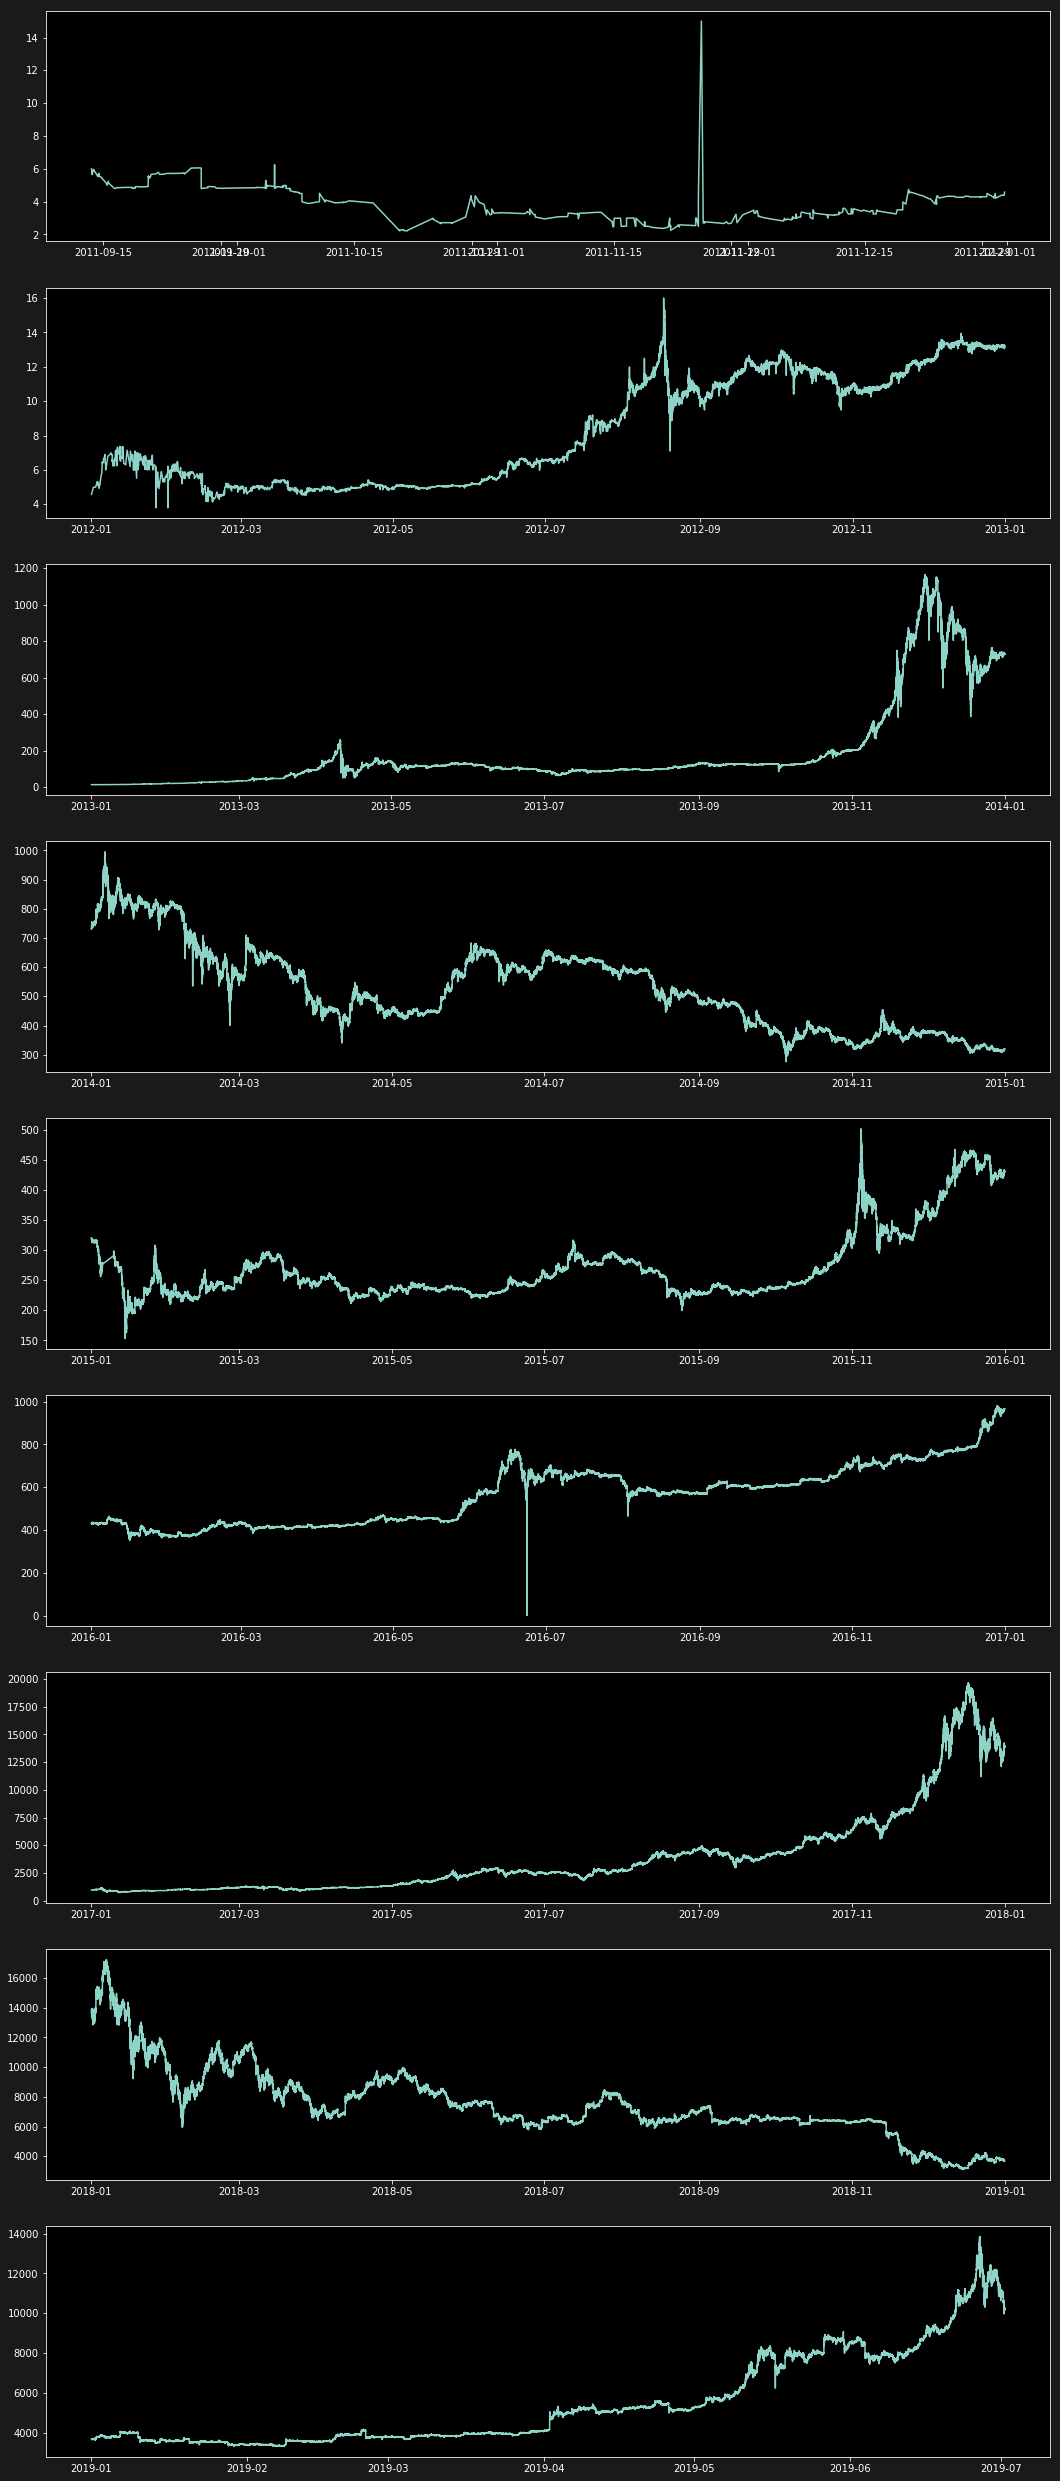

In [0]:
rate_history(data_1, 'price_close')

In [0]:
pd.Series(data_1.index).diff().nunique()

563

In [0]:
data_1.index[(pd.Series(data_1.index).diff() > pd.Timedelta('1T')).to_list()].year.value_counts()

2016    91001
2015    78599
2014    73476
2013    59043
2017    29767
2012    17823
2018    15146
2019    11030
2011      392
Name: time_period_start, dtype: int64

In [0]:
data_1.index[(pd.Series(data_1.index).diff() > pd.Timedelta('1H')).to_list()].year.value_counts()

2012    1883
2011     258
2013     163
2014       3
2019       1
2015       1
2018       1
Name: time_period_start, dtype: int64

In [0]:
data_1.index[(pd.Series(data_1.index).diff() > pd.Timedelta('12H')).to_list()].year.value_counts()

2011    68
2012    38
2015     1
Name: time_period_start, dtype: int64

In [0]:
data_1.index[(pd.Series(data_1.index).diff() > pd.Timedelta('1D')).to_list()].year.value_counts()

2011    23
2012     3
2015     1
Name: time_period_start, dtype: int64

##BITSTAMP_SPOT_BTC_USD_1MIN_tslab

In [0]:
data_2 = pd.read_csv(
    f'data/{files[1]}',
    parse_dates=['<DATE>']
    )
data_2.head()

,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,bitstamp,1,2011-09-13,135300,5.80,6.00,5.80,6.00,25.000000
1,bitstamp,1,2011-09-13,143200,5.95,5.95,5.95,5.95,12.452100
2,bitstamp,1,2011-09-13,143500,5.88,5.88,5.88,5.88,7.458000
3,bitstamp,1,2011-09-13,143600,5.88,5.88,5.88,5.88,0.176882
4,bitstamp,1,2011-09-13,145400,5.76,5.76,5.76,5.76,2.267000


In [0]:
data_2 = parse_data(data_2)
data_2.head()

,open,high,low,close,vol
dt,,,,,
2011-09-13 13:53:00,5.80,6.00,5.80,6.00,25.000000
2011-09-13 14:32:00,5.95,5.95,5.95,5.95,12.452100
2011-09-13 14:35:00,5.88,5.88,5.88,5.88,7.458000
2011-09-13 14:36:00,5.88,5.88,5.88,5.88,0.176882
2011-09-13 14:54:00,5.76,5.76,5.76,5.76,2.267000


In [0]:
pd.Series(data_2.index).diff().nunique()

563

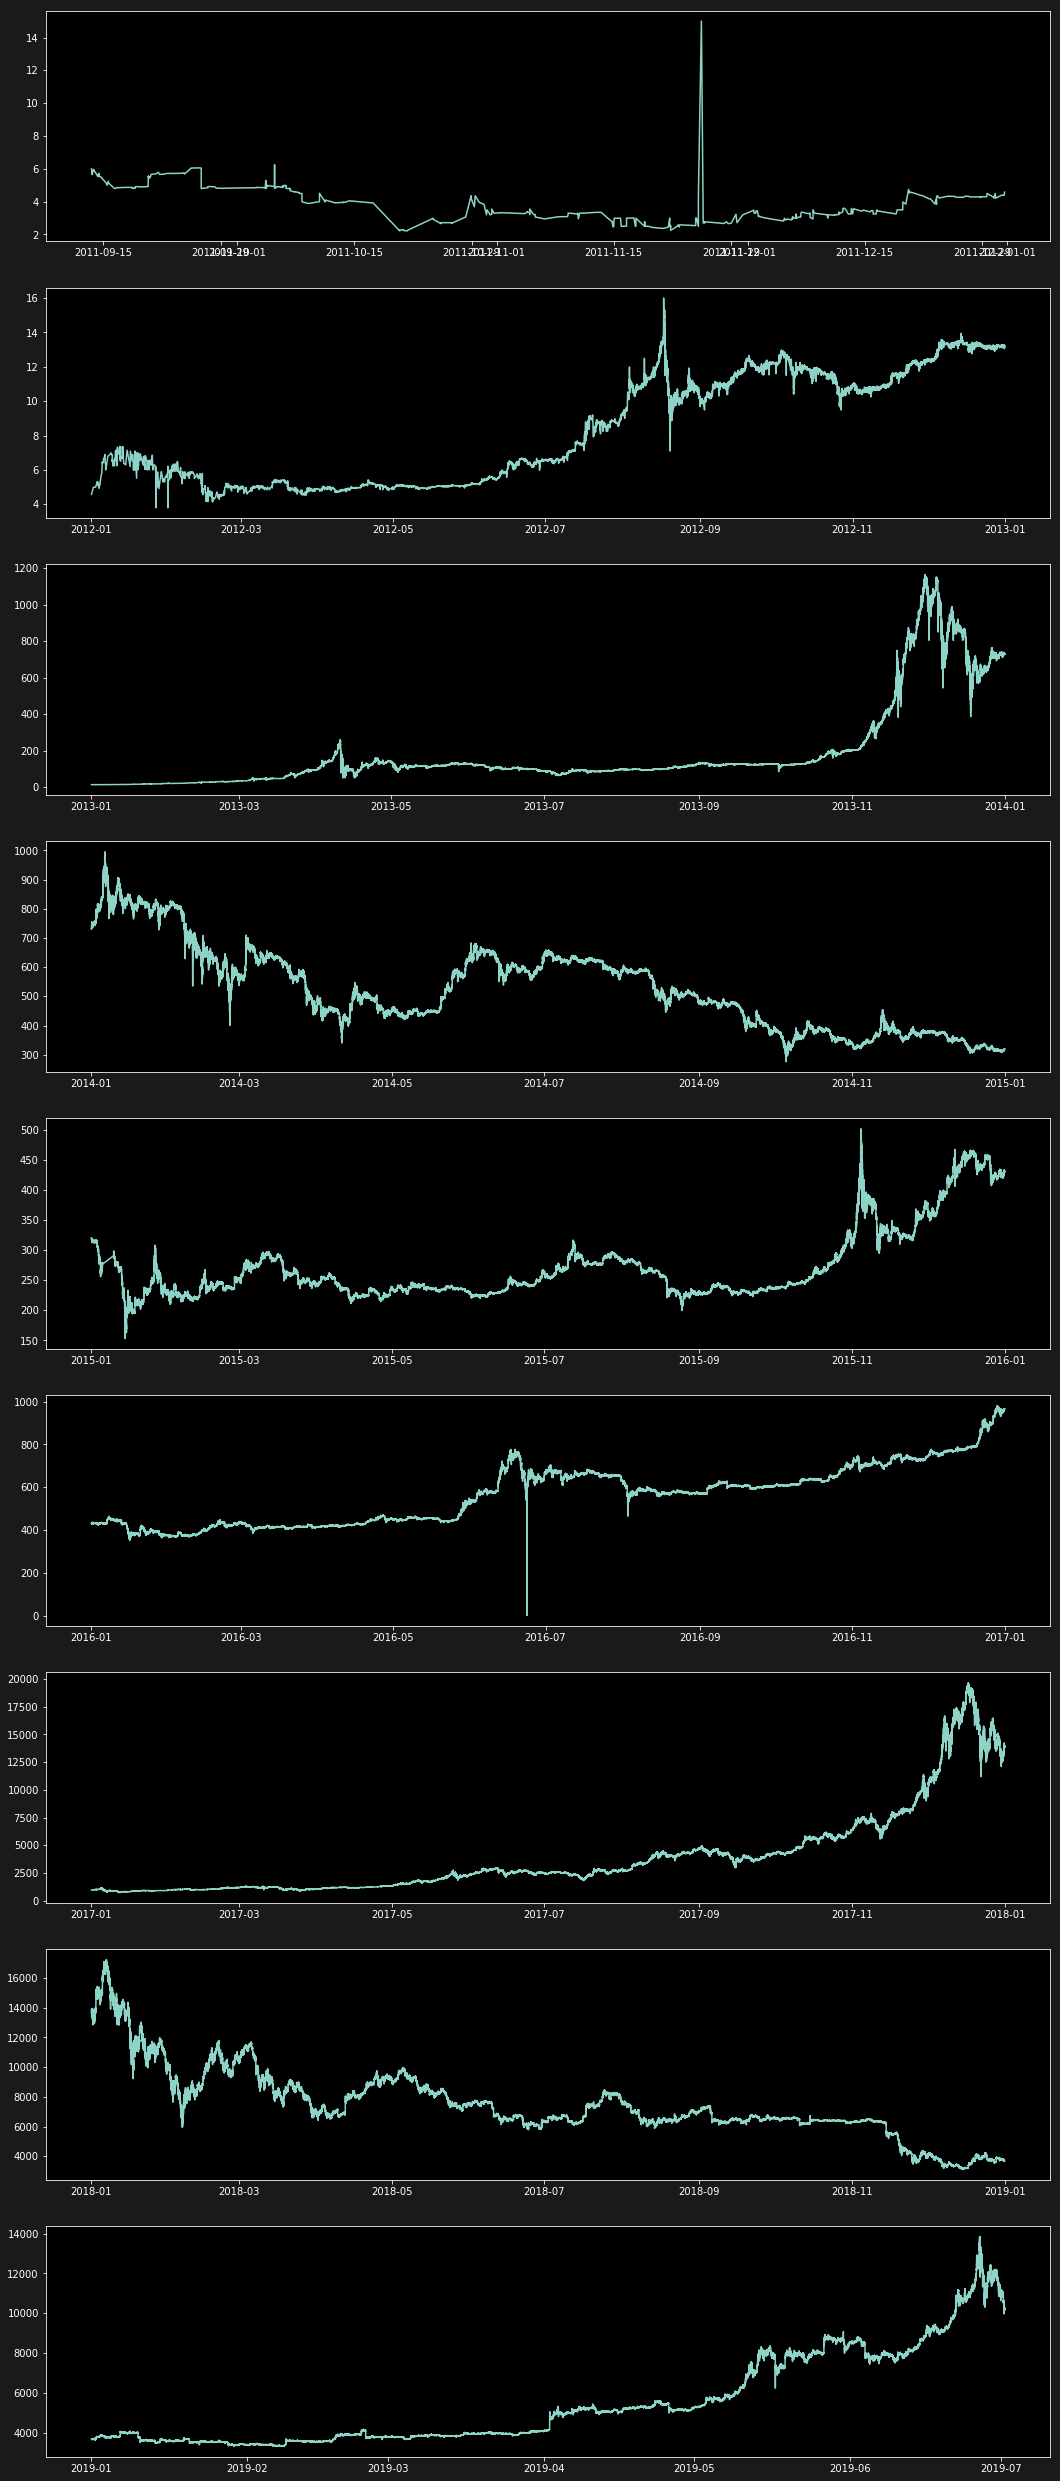

In [0]:
rate_history(data_2, 'close')

##TSLAB_1m_BTUSD_bitfinex

In [0]:
data_3 = pd.read_csv(
    f'data/{files[2]}',
    parse_dates=['<DATE>']
    )
data_3.head()

,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,bitfinex,1,2015-01-01,0,322.31,322.31,322.09,322.09,62.874248
1,bitfinex,1,2015-01-01,100,321.64,322.26,321.64,322.26,5.929470
2,bitfinex,1,2015-01-01,200,322.05,322.05,322.05,322.05,2.000000
3,bitfinex,1,2015-01-01,300,321.89,321.89,321.88,321.88,2.532000
4,bitfinex,1,2015-01-01,400,321.84,321.84,321.84,321.84,0.643100


In [0]:
data_3 = parse_data(data_3)
data_3.head()

,open,high,low,close,vol
dt,,,,,
2015-01-01 00:00:00,322.31,322.31,322.09,322.09,62.874248
2015-01-01 00:01:00,321.64,322.26,321.64,322.26,5.929470
2015-01-01 00:02:00,322.05,322.05,322.05,322.05,2.000000
2015-01-01 00:03:00,321.89,321.89,321.88,321.88,2.532000
2015-01-01 00:04:00,321.84,321.84,321.84,321.84,0.643100


In [0]:
pd.Series(data_3.index).diff().nunique()

1

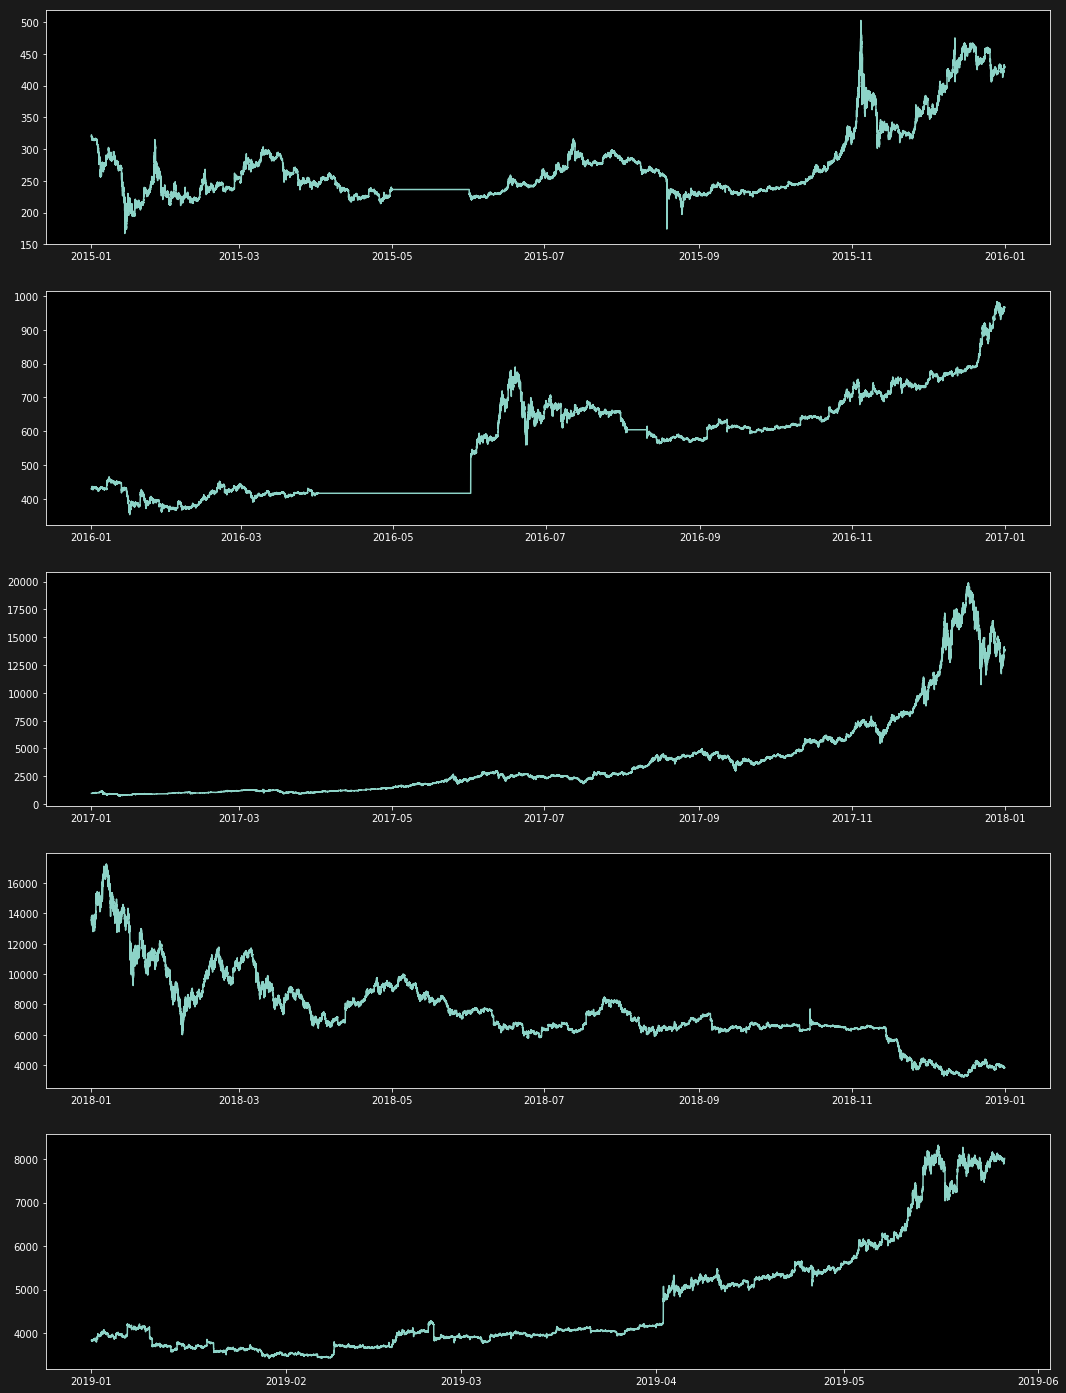

In [0]:
rate_history(data_3, 'close')

##TSLAB_1m_ETHUSD_bitfinex

In [0]:
data_4 = pd.read_csv(
    f'data/{files[3]}',
    parse_dates=['<DATE>']
    )
data_4.head()

,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,bitfinex,1,2016-03-09,160400,10.297,10.297,10.097,10.097,0.03
1,bitfinex,1,2016-03-09,160500,10.297,10.297,10.097,10.097,0.00
2,bitfinex,1,2016-03-09,160600,10.297,10.297,10.097,10.097,0.00
3,bitfinex,1,2016-03-09,160700,10.297,10.297,10.097,10.097,0.00
4,bitfinex,1,2016-03-09,160800,10.297,10.297,10.097,10.097,0.00


In [0]:
data_4 = parse_data(data_4)
data_4.head()

,open,high,low,close,vol
dt,,,,,
2016-03-09 16:04:00,10.297,10.297,10.097,10.097,0.03
2016-03-09 16:05:00,10.297,10.297,10.097,10.097,0.00
2016-03-09 16:06:00,10.297,10.297,10.097,10.097,0.00
2016-03-09 16:07:00,10.297,10.297,10.097,10.097,0.00
2016-03-09 16:08:00,10.297,10.297,10.097,10.097,0.00


In [0]:
pd.Series(data_4.index).diff().nunique()

1

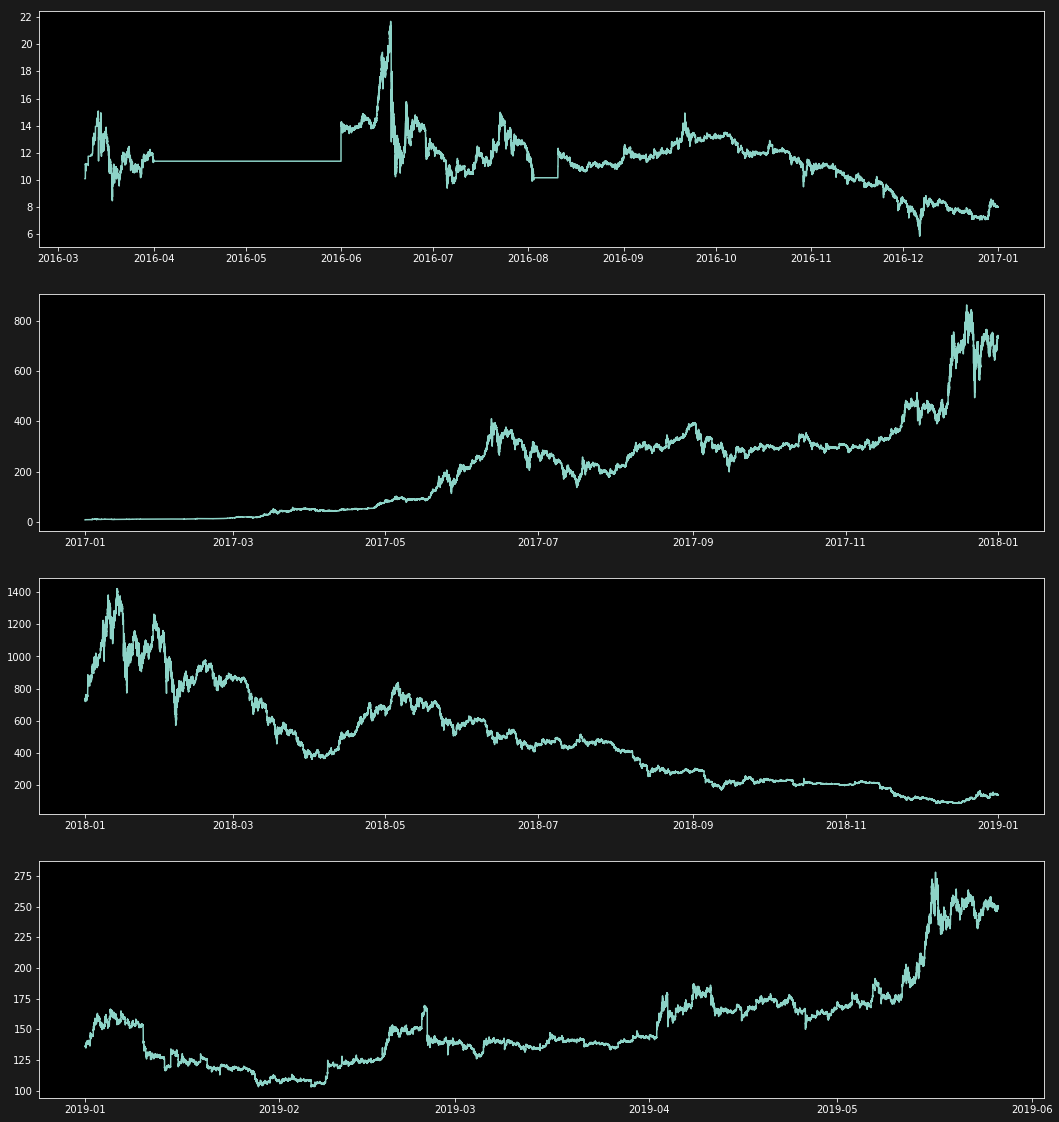

In [0]:
rate_history(data_4, 'close')

In [0]:
data_4_5m = resemple_data(data_4, '5T')
data_4_5m.head()

,open,high,low,close,vol
dt,,,,,
2016-03-09 16:00:00,10.297,10.297,10.097,10.097,0.03
2016-03-09 16:05:00,10.297,10.297,10.097,10.097,0.00
2016-03-09 16:10:00,10.297,10.297,10.097,10.097,0.00
2016-03-09 16:15:00,10.297,10.297,10.097,10.097,0.00
2016-03-09 16:20:00,10.297,10.297,10.097,10.097,0.00


In [0]:
data_scale_4_5m, scaler_4 = standart_scale(data_4_5m)
data_scale_4_5m

array([[-0.86800786, -0.86773458, -0.86906825, -0.86876891, -0.39598127],
       [-0.86800786, -0.86773458, -0.86906825, -0.86876891, -0.39599947],
       [-0.86800786, -0.86773458, -0.86906825, -0.86876891, -0.39599947],
       ...,
       [ 0.03776528,  0.03672334,  0.03988486,  0.03787629, -0.33354836],
       [ 0.03787866,  0.03587745,  0.03723234,  0.03515525, -0.33858852],
       [ 0.03591347,  0.03589403,  0.0379902 ,  0.03787629,  0.10320861]])

In [0]:
data_scale_4_5m.shape

(337825, 5)

In [0]:
x_train, y_train = get_xy(
    data_scale_4_5m[(data_4_5m.index >= pd.Timestamp(2016, 9, 1)) & (data_4_5m.index < pd.Timestamp(2018, 6, 1))],
    500
    )
x_train.shape

(183244, 500, 5)

In [0]:
y_train[:, 3].shape

(183244,)

In [0]:
x_val, y_val = get_xy(data_scale_4_5m[(data_4_5m.index >= pd.Timestamp(2018, 6, 1)) & (data_4_5m.index < pd.Timestamp(2019, 1, 1))], 500)
x_val.shape

(61132, 500, 5)

In [0]:
x_test, y_test = get_xy(data_scale_4_5m[data_4_5m.index >= pd.Timestamp(2019, 1, 1)], 500)
x_test.shape

(41453, 500, 5)

#END